# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 5e-4
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 144/144 [03:05<00:00,  1.29s/it]


[INFO] EPOCH: 1/100
Train loss: 0.613439, Test loss: 0.5053, Train IoU: 0.2538, Test IoU: 0.3515, Train Dice: 0.3936, Test Dice: 0.5233
Best IoU improved. Model saved.


100%|██████████| 144/144 [02:26<00:00,  1.01s/it]


[INFO] EPOCH: 2/100
Train loss: 0.434506, Test loss: 0.3338, Train IoU: 0.4033, Test IoU: 0.5252, Train Dice: 0.5725, Test Dice: 0.6947
Best IoU improved. Model saved.


100%|██████████| 144/144 [02:04<00:00,  1.16it/s]


[INFO] EPOCH: 3/100
Train loss: 0.274541, Test loss: 0.2273, Train IoU: 0.5791, Test IoU: 0.6598, Train Dice: 0.7325, Test Dice: 0.8013
Best IoU improved. Model saved.


100%|██████████| 144/144 [02:02<00:00,  1.17it/s]


[INFO] EPOCH: 4/100
Train loss: 0.206774, Test loss: 0.1972, Train IoU: 0.6669, Test IoU: 0.7003, Train Dice: 0.8002, Test Dice: 0.8313
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 5/100
Train loss: 0.189988, Test loss: 0.1865, Train IoU: 0.6896, Test IoU: 0.7149, Train Dice: 0.8170, Test Dice: 0.8420
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 6/100
Train loss: 0.180413, Test loss: 0.1794, Train IoU: 0.7028, Test IoU: 0.7248, Train Dice: 0.8266, Test Dice: 0.8491
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 7/100
Train loss: 0.175382, Test loss: 0.1774, Train IoU: 0.7098, Test IoU: 0.7275, Train Dice: 0.8316, Test Dice: 0.8512
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 8/100
Train loss: 0.173224, Test loss: 0.1757, Train IoU: 0.7127, Test IoU: 0.7298, Train Dice: 0.8338, Test Dice: 0.8529
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 9/100
Train loss: 0.171075, Test loss: 0.1729, Train IoU: 0.7158, Test IoU: 0.7338, Train Dice: 0.8359, Test Dice: 0.8556
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 10/100
Train loss: 0.168958, Test loss: 0.1711, Train IoU: 0.7187, Test IoU: 0.7364, Train Dice: 0.8380, Test Dice: 0.8575
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 11/100
Train loss: 0.168051, Test loss: 0.1717, Train IoU: 0.7200, Test IoU: 0.7353, Train Dice: 0.8389, Test Dice: 0.8568


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 12/100
Train loss: 0.166923, Test loss: 0.1706, Train IoU: 0.7216, Test IoU: 0.7369, Train Dice: 0.8401, Test Dice: 0.8580
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 13/100
Train loss: 0.166702, Test loss: 0.1688, Train IoU: 0.7219, Test IoU: 0.7395, Train Dice: 0.8403, Test Dice: 0.8598
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 14/100
Train loss: 0.165527, Test loss: 0.1689, Train IoU: 0.7235, Test IoU: 0.7394, Train Dice: 0.8415, Test Dice: 0.8597


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 15/100
Train loss: 0.165038, Test loss: 0.1695, Train IoU: 0.7243, Test IoU: 0.7385, Train Dice: 0.8420, Test Dice: 0.8591


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 16/100
Train loss: 0.164874, Test loss: 0.1682, Train IoU: 0.7244, Test IoU: 0.7403, Train Dice: 0.8421, Test Dice: 0.8604
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 17/100
Train loss: 0.163885, Test loss: 0.1674, Train IoU: 0.7259, Test IoU: 0.7416, Train Dice: 0.8431, Test Dice: 0.8612
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 18/100
Train loss: 0.164025, Test loss: 0.1675, Train IoU: 0.7257, Test IoU: 0.7414, Train Dice: 0.8430, Test Dice: 0.8611


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 19/100
Train loss: 0.163353, Test loss: 0.1669, Train IoU: 0.7266, Test IoU: 0.7422, Train Dice: 0.8436, Test Dice: 0.8617
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 20/100
Train loss: 0.163251, Test loss: 0.1670, Train IoU: 0.7268, Test IoU: 0.7420, Train Dice: 0.8437, Test Dice: 0.8616


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 21/100
Train loss: 0.162719, Test loss: 0.1663, Train IoU: 0.7276, Test IoU: 0.7430, Train Dice: 0.8443, Test Dice: 0.8622
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 22/100
Train loss: 0.156288, Test loss: 0.1248, Train IoU: 0.7378, Test IoU: 0.8078, Train Dice: 0.8507, Test Dice: 0.9038
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 23/100
Train loss: 0.109615, Test loss: 0.1087, Train IoU: 0.8107, Test IoU: 0.8331, Train Dice: 0.8974, Test Dice: 0.9198
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 24/100
Train loss: 0.103409, Test loss: 0.1064, Train IoU: 0.8205, Test IoU: 0.8367, Train Dice: 0.9036, Test Dice: 0.9222
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 25/100
Train loss: 0.101411, Test loss: 0.1044, Train IoU: 0.8236, Test IoU: 0.8400, Train Dice: 0.9056, Test Dice: 0.9242
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 26/100
Train loss: 0.099856, Test loss: 0.1042, Train IoU: 0.8261, Test IoU: 0.8402, Train Dice: 0.9071, Test Dice: 0.9244
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 27/100
Train loss: 0.099292, Test loss: 0.1028, Train IoU: 0.8270, Test IoU: 0.8423, Train Dice: 0.9077, Test Dice: 0.9257
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 28/100
Train loss: 0.098708, Test loss: 0.1039, Train IoU: 0.8279, Test IoU: 0.8407, Train Dice: 0.9083, Test Dice: 0.9247


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 29/100
Train loss: 0.098294, Test loss: 0.1019, Train IoU: 0.8286, Test IoU: 0.8439, Train Dice: 0.9087, Test Dice: 0.9267
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 30/100
Train loss: 0.097304, Test loss: 0.0952, Train IoU: 0.8303, Test IoU: 0.8558, Train Dice: 0.9097, Test Dice: 0.9334
Best IoU improved. Model saved.


100%|██████████| 144/144 [03:00<00:00,  1.25s/it]


[INFO] EPOCH: 31/100
Train loss: 0.087807, Test loss: 0.0879, Train IoU: 0.8465, Test IoU: 0.8675, Train Dice: 0.9192, Test Dice: 0.9407
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 32/100
Train loss: 0.084392, Test loss: 0.0865, Train IoU: 0.8521, Test IoU: 0.8698, Train Dice: 0.9226, Test Dice: 0.9420
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 33/100
Train loss: 0.083183, Test loss: 0.0858, Train IoU: 0.8541, Test IoU: 0.8710, Train Dice: 0.9238, Test Dice: 0.9428
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 34/100
Train loss: 0.082619, Test loss: 0.0846, Train IoU: 0.8550, Test IoU: 0.8729, Train Dice: 0.9244, Test Dice: 0.9439
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 35/100
Train loss: 0.082526, Test loss: 0.0847, Train IoU: 0.8551, Test IoU: 0.8727, Train Dice: 0.9245, Test Dice: 0.9438


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 36/100
Train loss: 0.081615, Test loss: 0.0839, Train IoU: 0.8567, Test IoU: 0.8741, Train Dice: 0.9254, Test Dice: 0.9446
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 37/100
Train loss: 0.081391, Test loss: 0.0840, Train IoU: 0.8571, Test IoU: 0.8740, Train Dice: 0.9256, Test Dice: 0.9446


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 38/100
Train loss: 0.081060, Test loss: 0.0834, Train IoU: 0.8576, Test IoU: 0.8750, Train Dice: 0.9259, Test Dice: 0.9452
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 39/100
Train loss: 0.080571, Test loss: 0.0848, Train IoU: 0.8585, Test IoU: 0.8725, Train Dice: 0.9264, Test Dice: 0.9437


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 40/100
Train loss: 0.080807, Test loss: 0.0830, Train IoU: 0.8580, Test IoU: 0.8756, Train Dice: 0.9262, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 41/100
Train loss: 0.080214, Test loss: 0.0837, Train IoU: 0.8590, Test IoU: 0.8744, Train Dice: 0.9268, Test Dice: 0.9449


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 42/100
Train loss: 0.080166, Test loss: 0.0830, Train IoU: 0.8591, Test IoU: 0.8756, Train Dice: 0.9268, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 43/100
Train loss: 0.079829, Test loss: 0.0832, Train IoU: 0.8597, Test IoU: 0.8752, Train Dice: 0.9272, Test Dice: 0.9453


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 44/100
Train loss: 0.079771, Test loss: 0.0828, Train IoU: 0.8597, Test IoU: 0.8759, Train Dice: 0.9272, Test Dice: 0.9458
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 45/100
Train loss: 0.079612, Test loss: 0.0825, Train IoU: 0.8600, Test IoU: 0.8765, Train Dice: 0.9274, Test Dice: 0.9461
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 46/100
Train loss: 0.080661, Test loss: 0.0825, Train IoU: 0.8583, Test IoU: 0.8763, Train Dice: 0.9263, Test Dice: 0.9460


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 47/100
Train loss: 0.079309, Test loss: 0.0822, Train IoU: 0.8605, Test IoU: 0.8769, Train Dice: 0.9277, Test Dice: 0.9464
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 48/100
Train loss: 0.079852, Test loss: 0.0819, Train IoU: 0.8597, Test IoU: 0.8775, Train Dice: 0.9271, Test Dice: 0.9466
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 49/100
Train loss: 0.077347, Test loss: 0.0786, Train IoU: 0.8641, Test IoU: 0.8833, Train Dice: 0.9296, Test Dice: 0.9499
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 50/100
Train loss: 0.073128, Test loss: 0.0748, Train IoU: 0.8715, Test IoU: 0.8900, Train Dice: 0.9339, Test Dice: 0.9538
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 51/100
Train loss: 0.069354, Test loss: 0.0715, Train IoU: 0.8781, Test IoU: 0.8958, Train Dice: 0.9376, Test Dice: 0.9571
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 52/100
Train loss: 0.066379, Test loss: 0.0691, Train IoU: 0.8833, Test IoU: 0.9000, Train Dice: 0.9406, Test Dice: 0.9595
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 53/100
Train loss: 0.064527, Test loss: 0.0672, Train IoU: 0.8865, Test IoU: 0.9032, Train Dice: 0.9425, Test Dice: 0.9614
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 54/100
Train loss: 0.062986, Test loss: 0.0672, Train IoU: 0.8892, Test IoU: 0.9032, Train Dice: 0.9440, Test Dice: 0.9614


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 55/100
Train loss: 0.061831, Test loss: 0.0651, Train IoU: 0.8913, Test IoU: 0.9068, Train Dice: 0.9452, Test Dice: 0.9634
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 56/100
Train loss: 0.061516, Test loss: 0.0655, Train IoU: 0.8918, Test IoU: 0.9061, Train Dice: 0.9455, Test Dice: 0.9631


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 57/100
Train loss: 0.060690, Test loss: 0.0647, Train IoU: 0.8933, Test IoU: 0.9074, Train Dice: 0.9463, Test Dice: 0.9638
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 58/100
Train loss: 0.059891, Test loss: 0.0638, Train IoU: 0.8946, Test IoU: 0.9090, Train Dice: 0.9471, Test Dice: 0.9648
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 59/100
Train loss: 0.059581, Test loss: 0.0636, Train IoU: 0.8952, Test IoU: 0.9094, Train Dice: 0.9474, Test Dice: 0.9650
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 60/100
Train loss: 0.059152, Test loss: 0.0633, Train IoU: 0.8959, Test IoU: 0.9099, Train Dice: 0.9478, Test Dice: 0.9653
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 61/100
Train loss: 0.058929, Test loss: 0.0635, Train IoU: 0.8963, Test IoU: 0.9096, Train Dice: 0.9481, Test Dice: 0.9651


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 62/100
Train loss: 0.058965, Test loss: 0.0631, Train IoU: 0.8962, Test IoU: 0.9102, Train Dice: 0.9480, Test Dice: 0.9655
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 63/100
Train loss: 0.058461, Test loss: 0.0627, Train IoU: 0.8971, Test IoU: 0.9110, Train Dice: 0.9485, Test Dice: 0.9659
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 64/100
Train loss: 0.058303, Test loss: 0.0633, Train IoU: 0.8974, Test IoU: 0.9099, Train Dice: 0.9487, Test Dice: 0.9652


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 65/100
Train loss: 0.058243, Test loss: 0.0629, Train IoU: 0.8975, Test IoU: 0.9107, Train Dice: 0.9487, Test Dice: 0.9657


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 66/100
Train loss: 0.057875, Test loss: 0.0626, Train IoU: 0.8982, Test IoU: 0.9112, Train Dice: 0.9491, Test Dice: 0.9660
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 67/100
Train loss: 0.057726, Test loss: 0.0622, Train IoU: 0.8984, Test IoU: 0.9118, Train Dice: 0.9493, Test Dice: 0.9664
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 68/100
Train loss: 0.057754, Test loss: 0.0626, Train IoU: 0.8983, Test IoU: 0.9111, Train Dice: 0.9492, Test Dice: 0.9660


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 69/100
Train loss: 0.057839, Test loss: 0.0620, Train IoU: 0.8981, Test IoU: 0.9122, Train Dice: 0.9492, Test Dice: 0.9666
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 70/100
Train loss: 0.057693, Test loss: 0.0621, Train IoU: 0.8985, Test IoU: 0.9119, Train Dice: 0.9493, Test Dice: 0.9664


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 71/100
Train loss: 0.057682, Test loss: 0.0624, Train IoU: 0.8984, Test IoU: 0.9115, Train Dice: 0.9493, Test Dice: 0.9662


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 72/100
Train loss: 0.057998, Test loss: 0.0620, Train IoU: 0.8979, Test IoU: 0.9121, Train Dice: 0.9490, Test Dice: 0.9665


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 73/100
Train loss: 0.057217, Test loss: 0.0617, Train IoU: 0.8993, Test IoU: 0.9126, Train Dice: 0.9498, Test Dice: 0.9668
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 74/100
Train loss: 0.056994, Test loss: 0.0649, Train IoU: 0.8996, Test IoU: 0.9071, Train Dice: 0.9500, Test Dice: 0.9637


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 75/100
Train loss: 0.061305, Test loss: 0.0622, Train IoU: 0.8920, Test IoU: 0.9118, Train Dice: 0.9457, Test Dice: 0.9664


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 76/100
Train loss: 0.056982, Test loss: 0.0616, Train IoU: 0.8996, Test IoU: 0.9129, Train Dice: 0.9500, Test Dice: 0.9670
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 77/100
Train loss: 0.056586, Test loss: 0.0614, Train IoU: 0.9003, Test IoU: 0.9133, Train Dice: 0.9504, Test Dice: 0.9672
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 78/100
Train loss: 0.056375, Test loss: 0.0614, Train IoU: 0.9007, Test IoU: 0.9132, Train Dice: 0.9506, Test Dice: 0.9672


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 79/100
Train loss: 0.056410, Test loss: 0.0612, Train IoU: 0.9007, Test IoU: 0.9136, Train Dice: 0.9506, Test Dice: 0.9674
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 80/100
Train loss: 0.056283, Test loss: 0.0611, Train IoU: 0.9010, Test IoU: 0.9137, Train Dice: 0.9507, Test Dice: 0.9674
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 81/100
Train loss: 0.056419, Test loss: 0.0617, Train IoU: 0.9007, Test IoU: 0.9127, Train Dice: 0.9506, Test Dice: 0.9669


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 82/100
Train loss: 0.056554, Test loss: 0.0615, Train IoU: 0.9004, Test IoU: 0.9130, Train Dice: 0.9504, Test Dice: 0.9671


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 83/100
Train loss: 0.056248, Test loss: 0.0615, Train IoU: 0.9010, Test IoU: 0.9130, Train Dice: 0.9507, Test Dice: 0.9670


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 84/100
Train loss: 0.056420, Test loss: 0.0613, Train IoU: 0.9007, Test IoU: 0.9134, Train Dice: 0.9506, Test Dice: 0.9673


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 85/100
Train loss: 0.056552, Test loss: 0.0614, Train IoU: 0.9004, Test IoU: 0.9132, Train Dice: 0.9504, Test Dice: 0.9672


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 86/100
Train loss: 0.056310, Test loss: 0.0615, Train IoU: 0.9009, Test IoU: 0.9130, Train Dice: 0.9507, Test Dice: 0.9671


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 87/100
Train loss: 0.056379, Test loss: 0.0614, Train IoU: 0.9007, Test IoU: 0.9131, Train Dice: 0.9506, Test Dice: 0.9671


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 88/100
Train loss: 0.056258, Test loss: 0.0612, Train IoU: 0.9009, Test IoU: 0.9136, Train Dice: 0.9507, Test Dice: 0.9674


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 89/100
Train loss: 0.055346, Test loss: 0.0548, Train IoU: 0.9026, Test IoU: 0.9251, Train Dice: 0.9516, Test Dice: 0.9737
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 90/100
Train loss: 0.047527, Test loss: 0.0516, Train IoU: 0.9168, Test IoU: 0.9309, Train Dice: 0.9595, Test Dice: 0.9770
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 91/100
Train loss: 0.039643, Test loss: 0.0341, Train IoU: 0.9314, Test IoU: 0.9631, Train Dice: 0.9673, Test Dice: 0.9944
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 92/100
Train loss: 0.028565, Test loss: 0.0305, Train IoU: 0.9520, Test IoU: 0.9697, Train Dice: 0.9784, Test Dice: 0.9980
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 93/100
Train loss: 0.026645, Test loss: 0.0295, Train IoU: 0.9555, Test IoU: 0.9716, Train Dice: 0.9803, Test Dice: 0.9990
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 94/100
Train loss: 0.025866, Test loss: 0.0293, Train IoU: 0.9570, Test IoU: 0.9720, Train Dice: 0.9811, Test Dice: 0.9992
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 95/100
Train loss: 0.025425, Test loss: 0.0289, Train IoU: 0.9579, Test IoU: 0.9729, Train Dice: 0.9816, Test Dice: 0.9997
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 96/100
Train loss: 0.024811, Test loss: 0.0275, Train IoU: 0.9590, Test IoU: 0.9755, Train Dice: 0.9822, Test Dice: 1.0011
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 97/100
Train loss: 0.023274, Test loss: 0.0265, Train IoU: 0.9620, Test IoU: 0.9773, Train Dice: 0.9837, Test Dice: 1.0021
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 98/100
Train loss: 0.022509, Test loss: 0.0262, Train IoU: 0.9634, Test IoU: 0.9779, Train Dice: 0.9845, Test Dice: 1.0024
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 99/100
Train loss: 0.022387, Test loss: 0.0259, Train IoU: 0.9637, Test IoU: 0.9784, Train Dice: 0.9846, Test Dice: 1.0027
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 100/100
Train loss: 0.021803, Test loss: 0.0256, Train IoU: 0.9648, Test IoU: 0.9791, Train Dice: 0.9852, Test Dice: 1.0030
Best IoU improved. Model saved.
[INFO] total time taken to train the model: 13644.09s
Best IoU is: 0.97906


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

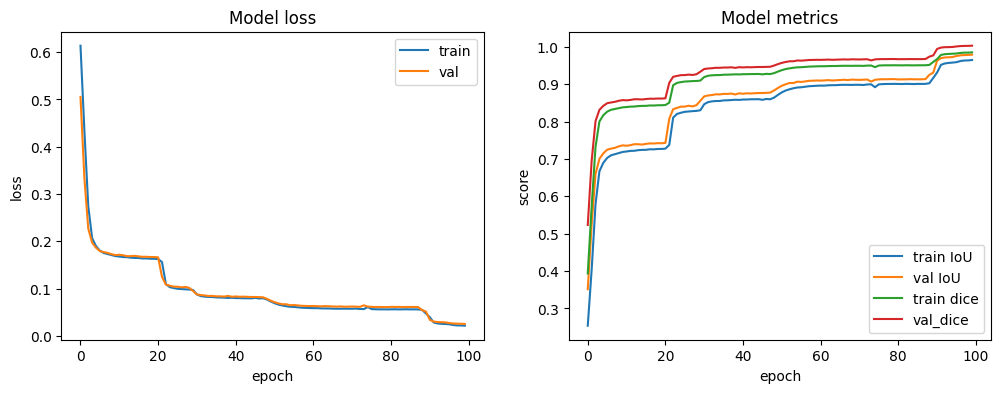

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

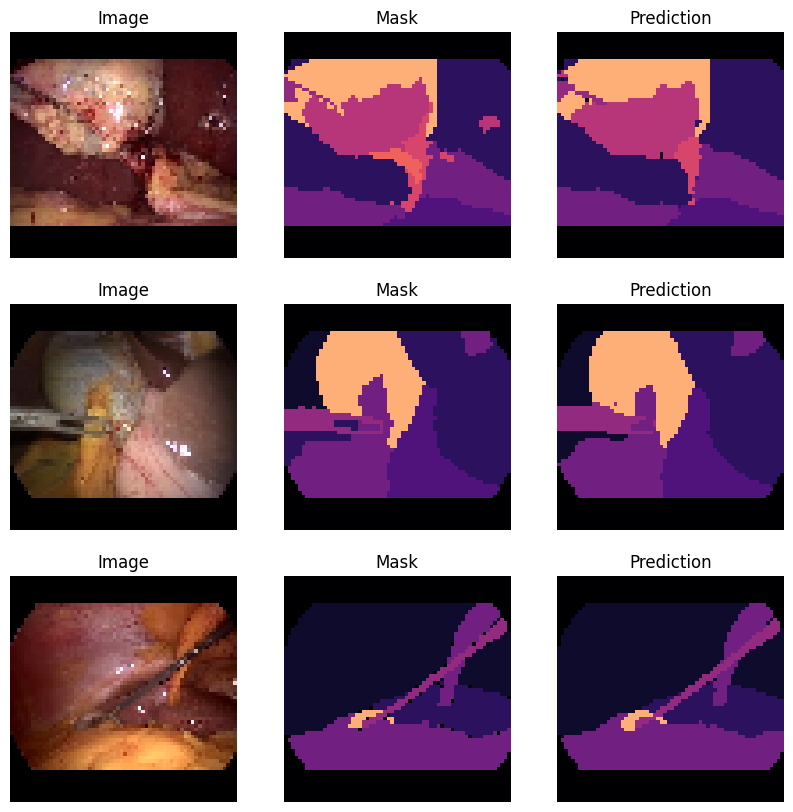

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota